# Customer2Vec

We learn good semantic representations for customers (users) from transactional data using doc2vec. Each customer is a document, orders are sentences, and products are words. We also compare Customer2Vec with the baseline representations obtained using k-means on manually designed features. 

| Property | Value |
|--|--|
| Description | NA (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
| Dataset | Instacart (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datsets.md)) |
| Papers | Arora2016, Stiebellehner2017 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | Download and unzip the dataset to 'data' folder |

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 8


## Data Exploration and Preparation

In [9]:
DATA_PATH = 'data/instacart-market-basket-analysis'
files_list = glob.glob(f'{DATA_PATH}/*.csv')

files_list

['data/instacart-market-basket-analysis/products.csv',
 'data/instacart-market-basket-analysis/orders.csv',
 'data/instacart-market-basket-analysis/order_products__train.csv',
 'data/instacart-market-basket-analysis/departments.csv',
 'data/instacart-market-basket-analysis/aisles.csv',
 'data/instacart-market-basket-analysis/order_products__prior.csv']

In [ ]:
data_dict = {}

for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(null_counts=True))
    data_dict[file.split('.')[0].split('/')[-1]] = data

print(f'Loaded data sets: {data_dict.keys()}')

## Establishing the Baselines: Basic Segmentation in a Manually Designed Feature Space

We start with designing several basic features and segmenting customers using this basic representation. Note that the dataset is also very limited and does not allow for advanced ferature engineering (there is no demographic data, etc). 

### Feature Engineering

In [4]:
train_orders = data_dict['order_products__train']
prior_orders = data_dict['order_products__prior']
products = data_dict['products'].set_index('product_id')

orders = data_dict['orders']
prior_orders = prior_orders.merge(right=orders[['user_id','order_id','order_number']],on='order_id',how='left')

prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


In [5]:
# Sample users to keep the problem computationaly tractable 
USER_SUBSET = 50000
user_ids_sample = prior_orders['user_id'].sample(n=USER_SUBSET, replace=False)

In [6]:
prior_orders_details = prior_orders[prior_orders.user_id.isin(user_ids_sample)].copy()
prior_orders_details['product_id'] = prior_orders_details['product_id'].astype(int)
prior_orders_details = prior_orders_details.merge(data_dict['products'], on='product_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['aisles'], on='aisle_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['departments'], on='department_id', how='left')

prior_orders_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,3,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,3,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,3,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,3,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,3,Natural Sweetener,17,13,baking ingredients,pantry


In [7]:
# Create basic user features: relative purchase frequences in each depertment/aisle

feature_department = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['department'], aggfunc='count', fill_value=0)
feature_department = feature_department.div(feature_department.sum(axis=1), axis=0)
feature_department.columns = feature_department.columns.droplevel(0)
feature_department = feature_department.reset_index()

feature_aisle = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['aisle'], aggfunc='count', fill_value=0)
feature_aisle = feature_aisle.div(feature_aisle.sum(axis=1), axis=0)
feature_aisle.columns = feature_aisle.columns.droplevel(0)
feature_aisle = feature_aisle.reset_index()

feature_df = feature_department.merge(feature_aisle, how='left', on='user_id').set_index('user_id')

feature_df.iloc[:5, :10] # show first 10 columns (departments) only

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta
user_id,,,,,,,,,,
8,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.102041,0.244898,0.000000,0.020408
27,0.000000,0.0,0.024740,0.449219,0.014323,0.0,0.000000,0.272135,0.001302,0.000000
35,0.000000,0.0,0.070652,0.027174,0.027174,0.0,0.005435,0.206522,0.027174,0.032609
36,0.189542,0.0,0.026144,0.104575,0.000000,0.0,0.006536,0.019608,0.052288,0.052288
38,0.000000,0.0,0.041026,0.153846,0.000000,0.0,0.030769,0.241026,0.056410,0.035897


### Visualize the Basic Space Using t-SNE  

In [11]:
from sklearn.preprocessing import MinMaxScaler

mm_scale = MinMaxScaler()
feature_df_scale = pd.DataFrame(mm_scale.fit_transform(feature_df),
                                columns=feature_df.columns,
                                index=feature_df.index.values)

tsne_doc_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_features_doc = tsne_doc_features.fit_transform(feature_df_scale.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38215 samples in 2.376s...
[t-SNE] Computed neighbors for 38215 samples in 493.422s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38215
[t-SNE] Computed conditional probabilities for sample 2000 / 38215
[t-SNE] Computed conditional probabilities for sample 3000 / 38215
[t-SNE] Computed conditional probabilities for sample 4000 / 38215
[t-SNE] Computed conditional probabilities for sample 5000 / 38215
[t-SNE] Computed conditional probabilities for sample 6000 / 38215
[t-SNE] Computed conditional probabilities for sample 7000 / 38215
[t-SNE] Computed conditional probabilities for sample 8000 / 38215
[t-SNE] Computed conditional probabilities for sample 9000 / 38215
[t-SNE] Computed conditional probabilities for sample 10000 / 38215
[t-SNE] Computed conditional probabilities for sample 11000 / 38215
[t-SNE] Computed conditional probabilities for sample 12000 / 38215
[t-SNE] Computed conditional probabilities for s

In [12]:
tsne_doc_features = pd.DataFrame({'user_id':feature_df.index.values})
tsne_doc_features['tsne-2d-one'] = tsne_features_doc[:,0]
tsne_doc_features['tsne-2d-two'] = tsne_features_doc[:,1]

<Figure size 1152x720 with 0 Axes>

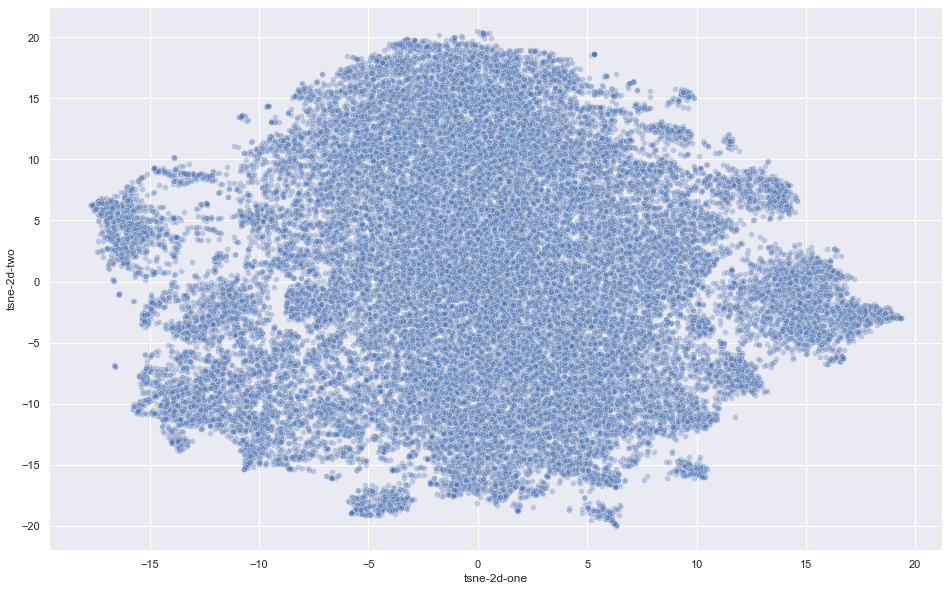

In [13]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc_features,
    legend="full",
    alpha=0.3
)
plt.show()

In [14]:
# Computing silhouette scores for different clustering option
silhouette_list = []
for k in tqdm(range(2, 12, 2)):
    clusters = KMeans(n_clusters=k).fit(feature_df_scale).labels_.astype(float)
    silhouette_avg = silhouette_score(feature_df_scale, clusters, metric="euclidean")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

Silhouette score for 2 clusters is : 0.1136
Silhouette score for 4 clusters is : 0.04837
Silhouette score for 6 clusters is : 0.03828
Silhouette score for 8 clusters is : 0.0385
Silhouette score for 10 clusters is : 0.0253



<Figure size 720x432 with 0 Axes>

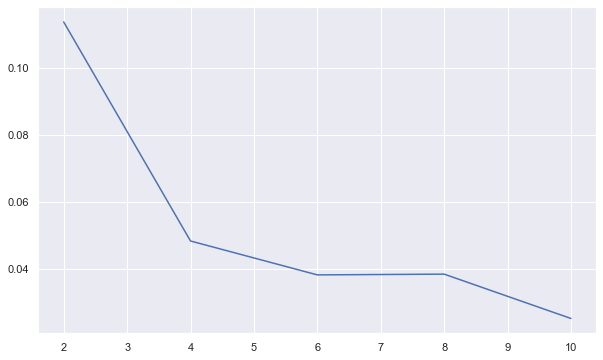

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 12, 2), silhouette_list)

Conclusions: We can see from the t-SNE visualization it is possible to detect 2-3 clusters, but the silhouette score is close to zero and this feature space is not a good choice for customer segmentation. 
We should develop more advanced features and incorporate more domain knowledge to obtain better feature space for segmentation.

## Customer2Vec, Step 1: Data Preparation 

In this and next section, we are learning and exploring the customer semantic space using Doc2Vec.

In [16]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

# It is important to sort order and products chronologically
prior_orders.sort_values(by=['user_id','order_number','add_to_cart_order'], inplace=True)

In [17]:
combined_orders_by_user_id = prior_orders.groupby("user_id").apply(lambda order: ' '.join(order['product_id'].tolist()))

combined_orders_by_user_id = pd.DataFrame(combined_orders_by_user_id,columns=['all_orders'])
print(f'Number of orders: {combined_orders_by_user_id.shape[0]}')
combined_orders_by_user_id.reset_index(inplace=True)
combined_orders_by_user_id.user_id = combined_orders_by_user_id.user_id.astype(str)

combined_orders_by_user_id.head()

Number of orders: 206209


,user_id,all_orders
0,1,196 14084 12427 26088 26405 196 10258 12427 13176 26088 13032 196 12427 10258 25133 30450 196 12427 10258 25133 26405 196 12427 10258 25133 10326 17122 41787 13176 196 12427 10258 25133 196 10258 ...
1,2,32792 47766 20574 12000 48110 22474 16589 35917 27344 30489 27966 13176 45066 16797 47526 8479 47766 19051 8138 47766 32792 20574 7781 28874 49451 32792 32139 34688 36735 37646 22829 24852 47209 3...
2,3,9387 17668 15143 16797 39190 47766 21903 39922 24810 32402 38596 21903 248 40604 8021 17668 21137 23650 32402 39190 47766 21903 49683 28373 7503 1819 12845 9387 16965 24010 39190 9387 17668 47766 ...
3,4,36606 7350 35469 2707 42329 7160 1200 17769 43704 37646 11865 35469 19057 22199 25146 26576 25623 21573
4,5,15349 21413 48775 28289 8518 11777 31717 26604 43693 22475 24535 43693 6808 24535 11777 21616 18761 26604 13870 13988 26604 11777 20754 24231 40706 27344 24535 43693 40706 16168 21413 13988 3376 8...


## Customer2Vec, Step 2: Train Doc2Vec model

We use implementation from Gensim adjusting the following parameters:
* documents = users (each user is represented by a chronologically sorted list of products)
* window - Maximum distance between the current and predicted word within a sentence.
* vector_size - Dimensionality of the word vectors.
* min_count - Ignores all words with total frequency lower than this.

Note that model training can take a long time (10+ hours).

In [18]:
TRAIN_USER_MODEL = False    # True - create a new model, False - load a previosuly created model
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [19]:
from gensim.models.doc2vec import LabeledSentence, TaggedDocument, Doc2Vec
import timeit
import gensim

embeddings_dim = 200    # dimensionality of user representation

filename = f'models/customer2vec.{embeddings_dim}d.model'
if TRAIN_USER_MODEL:

    class TaggedDocumentIterator(object):
        def __init__(self, df):
           self.df = df
        def __iter__(self):
            for row in self.df.itertuples():
                yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['user_id']])

    it = TaggedDocumentIterator(combined_orders_by_user_id)

    doc_model = gensim.models.Doc2Vec(vector_size=embeddings_dim, 
                                      window=5, 
                                      min_count=10, 
                                      workers=mp.cpu_count(),
                                      alpha=0.055, 
                                      min_alpha=0.055,
                                      epochs=120)   # use fixed learning rate

    train_corpus = list(it)

    doc_model.build_vocab(train_corpus)

    for epoch in tqdm(range(10)):
        doc_model.alpha -= 0.005                    # decrease the learning rate
        doc_model.min_alpha = doc_model.alpha       # fix the learning rate, no decay
        doc_model.train(train_corpus, total_examples=doc_model.corpus_count, epochs=doc_model.iter)
        print('Iteration:', epoch)

    doc_model.save(filename)
    print(f'Model saved to [{filename}]')
    
else:
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

Model loaded from [models/customer2vec.200d.model]


In [20]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
doc_vector_dict = {arg:doc_model.docvecs[arg] for arg in vocab_doc}
X_doc = pd.DataFrame(doc_vector_dict).T.values


X_doc.shape, len(vocab_doc), prior_orders["user_id"].nunique()

((206209, 20), 206209, 206209)

## Customer2Vec, Step 3: Visualize the Customer Semantic Space Using t-SNE

In [21]:
user_ids_sample_str = set([str(id) for id in user_ids_sample])
idx = []
for i, user_id in enumerate(doc_vector_dict):
    if user_id in user_ids_sample_str:
        idx.append(i)
X_doc_subset = X_doc[idx] # only sampled user IDs
X_doc_subset.shape

(38215, 20)

In [22]:
doc_vec_subset = pd.DataFrame(doc_vector_dict).T.iloc[idx]
doc_vec_subset.shape

(38215, 20)

In [23]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc_subset, X_doc_subset, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38215 samples in 0.899s...
[t-SNE] Computed neighbors for 38215 samples in 88.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38215
[t-SNE] Computed conditional probabilities for sample 2000 / 38215
[t-SNE] Computed conditional probabilities for sample 3000 / 38215
[t-SNE] Computed conditional probabilities for sample 4000 / 38215
[t-SNE] Computed conditional probabilities for sample 5000 / 38215
[t-SNE] Computed conditional probabilities for sample 6000 / 38215
[t-SNE] Computed conditional probabilities for sample 7000 / 38215
[t-SNE] Computed conditional probabilities for sample 8000 / 38215
[t-SNE] Computed conditional probabilities for sample 9000 / 38215
[t-SNE] Computed conditional probabilities for sample 10000 / 38215
[t-SNE] Computed conditional probabilities for sample 11000 / 38215
[t-SNE] Computed conditional probabilities for sample 12000 / 38215
[t-SNE] Computed conditional probabilities for sa

In [24]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 1152x1152 with 0 Axes>

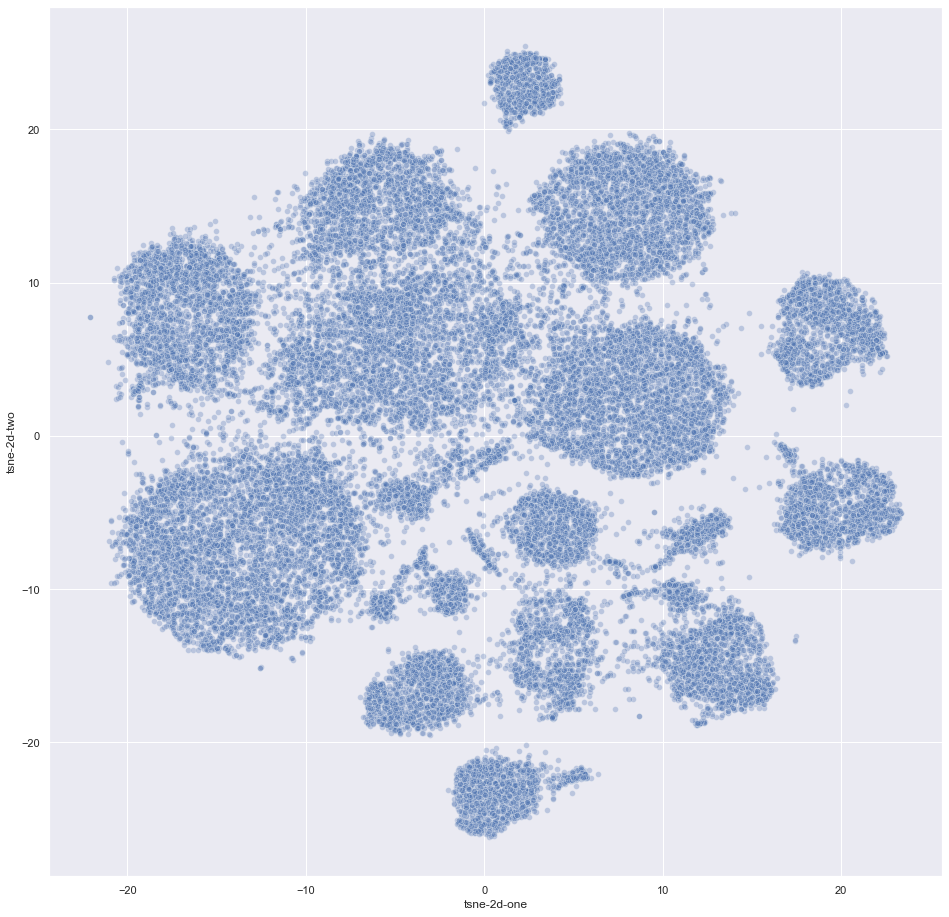

In [25]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

## Customer2Vec, Step 4: Segmentation in the Customer Semantic Space Using t-SNE

In [26]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc_subset)).labels_.astype(float)

silhouette_list = []
for k in tqdm(range(2, 22, 1)):
    latent_clusters = cluster_cosine(X_doc_subset, k)
    silhouette_avg = silhouette_score(X_doc_subset, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

Silhouette score for 2 clusters is : 0.2033
Silhouette score for 3 clusters is : 0.2157
Silhouette score for 4 clusters is : 0.2061
Silhouette score for 5 clusters is : 0.2224
Silhouette score for 6 clusters is : 0.2235
Silhouette score for 7 clusters is : 0.2384
Silhouette score for 8 clusters is : 0.2417
Silhouette score for 9 clusters is : 0.2553
Silhouette score for 10 clusters is : 0.2701
Silhouette score for 11 clusters is : 0.2843
Silhouette score for 12 clusters is : 0.2573
Silhouette score for 13 clusters is : 0.2699
Silhouette score for 14 clusters is : 0.2993
Silhouette score for 15 clusters is : 0.2972
Silhouette score for 16 clusters is : 0.276
Silhouette score for 17 clusters is : 0.2733
Silhouette score for 18 clusters is : 0.2724
Silhouette score for 19 clusters is : 0.265
Silhouette score for 20 clusters is : 0.2662
Silhouette score for 21 clusters is : 0.2597



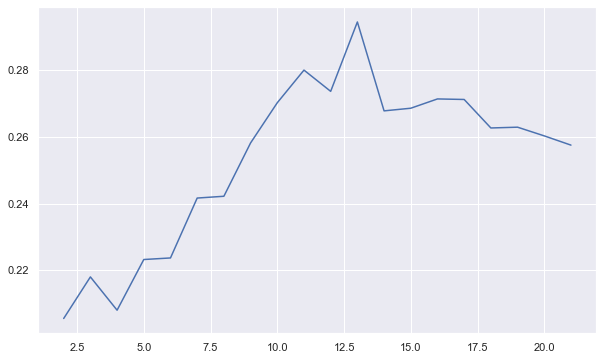

In [89]:
plt.figure(figsize=(10,6))
plt.plot(range(2,22,1), silhouette_list);

In [27]:
N_CLUSTER = 12

latent_clusters = cluster_cosine(X_doc_subset, N_CLUSTER)
doc_vec_end = doc_vec_subset.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

8.0     6632
4.0     4531
5.0     4266
2.0     3955
0.0     3347
11.0    3101
6.0     3084
10.0    2579
7.0     1795
1.0     1789
9.0     1652
3.0     1484
Name: label, dtype: int64

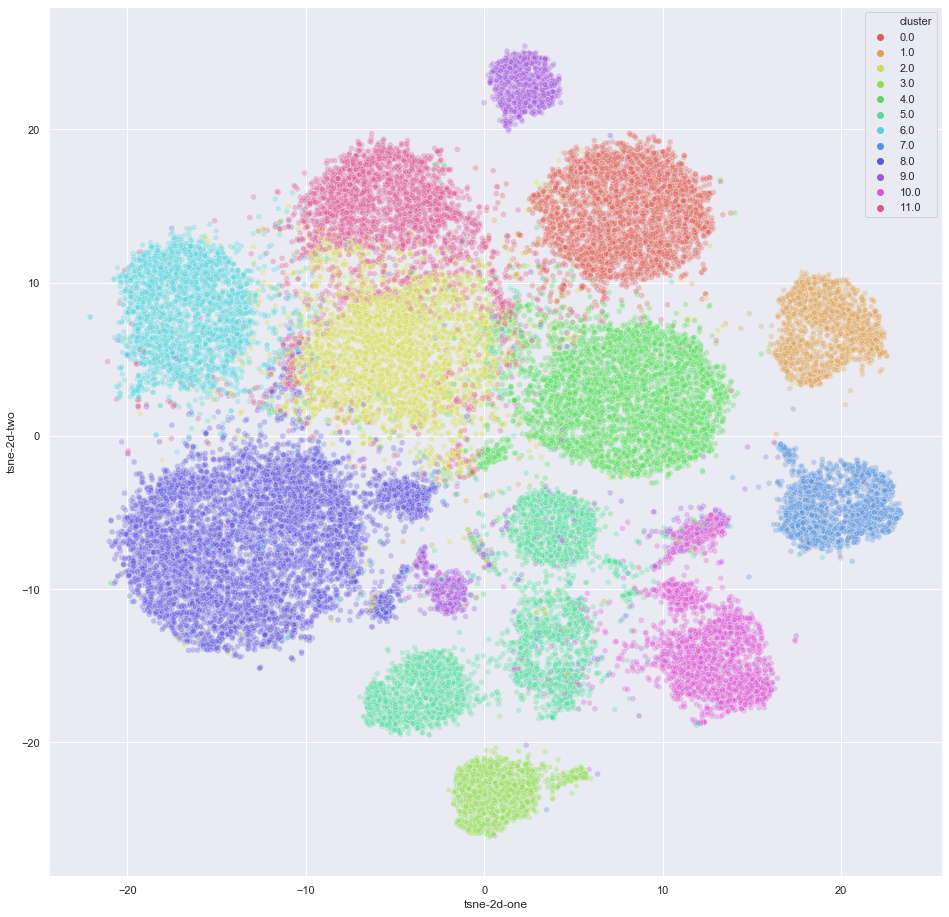

In [28]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();

In [48]:
feature_df['latent_cluster'] = latent_clusters

department_names = np.setdiff1d(prior_orders_details['department'].unique(), ['other', 'missing'])
interpetation_department = feature_df.groupby('latent_cluster')[department_names].mean()

interpetation_department.T.div(interpetation_department.sum(axis=1)).round(3)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
alcohol,0.006,0.005,0.005,0.005,0.006,0.005,0.007,0.006,0.006,0.005,0.005,0.005
babies,0.011,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.013,0.014,0.012
bakery,0.036,0.037,0.037,0.036,0.036,0.036,0.037,0.036,0.037,0.037,0.037,0.036
beverages,0.082,0.084,0.083,0.087,0.085,0.082,0.083,0.080,0.084,0.085,0.086,0.087
breakfast,0.021,0.022,0.022,0.022,0.022,0.022,0.020,0.022,0.021,0.022,0.022,0.021
bulk,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
canned goods,0.034,0.033,0.034,0.033,0.033,0.034,0.033,0.033,0.033,0.033,0.033,0.033
dairy eggs,0.166,0.166,0.165,0.164,0.167,0.166,0.165,0.163,0.166,0.165,0.168,0.166
deli,0.032,0.033,0.031,0.033,0.032,0.033,0.031,0.032,0.031,0.031,0.031,0.032
dry goods pasta,0.026,0.027,0.027,0.027,0.027,0.027,0.028,0.026,0.027,0.026,0.027,0.027


In [49]:
interpetation_aisle = feature_df.groupby('latent_cluster')[feature_df.columns.values[16:-1]].mean()
interpetation_aisle.T.div(interpetation_aisle.sum(axis=1)).round(3).head(20)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
pantry,0.040,0.039,0.041,0.039,0.040,0.040,0.040,0.041,0.040,0.039,0.041,0.040
personal care,0.010,0.010,0.010,0.010,0.010,0.010,0.009,0.010,0.009,0.009,0.010,0.010
pets,0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.002,0.002,0.002
produce,0.204,0.198,0.200,0.202,0.198,0.202,0.202,0.200,0.200,0.201,0.198,0.200
snacks,0.059,0.063,0.061,0.061,0.061,0.060,0.059,0.061,0.061,0.062,0.061,0.061
air fresheners candles,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
asian foods,0.004,0.004,0.004,0.004,0.003,0.004,0.004,0.003,0.004,0.004,0.003,0.004
baby accessories,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
baby bath body care,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
baby food formula,0.007,0.007,0.008,0.008,0.007,0.007,0.007,0.007,0.007,0.008,0.008,0.007


In [95]:
prior_orders_details_clustered = prior_orders_details.copy()
prior_orders_details_clustered = prior_orders_details_clustered.merge(feature_df['latent_cluster'], on='user_id', how='left')

for cluster_id in [7.0, 3.0]:
    prior_orders_details_clustered[prior_orders_details_clustered['latent_cluster']==cluster_id][['user_id', 'product_name']].groupby("user_id").apply(lambda order: ' > '.join(order['product_name'])).reset_index().head(5)

,user_id,0
0,8,"Organic Baby Spinach > Michigan Organic Kale > Bag of Lemons > Red Chili Flakes > Organic Thyme > Sage > Extra Sharp White Cheddar > Unsweetened Almondmilk > Unsalted Pure Irish Butter > Organic Salted Butter > Organic Yams > Cane Sugar > Carrots > Organic Premium Tomato Paste > Parsley, Italian (Flat), New England Grown > Low Sodium Beef Broth > Organic Dried Porcini Mushrooms > Organic Leek > Organic Coconut Cream > Organic Broccoli > Green Beans > Organic Leek > Unsalted Pure Irish Butter..."
1,52,Clementines > Dry Roasted Almonds > Zero Calorie Cola > Soda > 0% Greek Strained Yogurt > Crunchy Oats 'n Honey Granola Bars > Sprouted Sunflower Seeds > Bartlett Pears > Gala Apples > Spearmint > Hass Avocados > Clementines > Dry Roasted Almonds > Zero Calorie Cola > Soda > Hass Avocados > Smokehouse Almonds > Clementines > Zero Calorie Cola > Dry Roasted Almonds > Soda > Mozzarella String Cheese > Hass Avocados > Clementines > Dry Roasted Almonds > Organic Limes > 49 Flavors Jelly Belly Je...
2,303,Omeprazole Acid Reducer Tablets > Organic Spring Mix > Broccoli Florettes > Gold Kiwi > Raisin Bran > Unsalted Butter Quarters > Vegetable Oil > Omeprazole Acid Reducer Tablets > Omeprazole Acid Reducer Tablets > Raw Shrimp > Beef Franks > Original Hawaiian Sweet Rolls > Omeprazole Acid Reducer Tablets
3,341,"Whole Jersey Milk Low Pasteurized > Organic Hass Avocado > Organic Wheat-Free & Gluten-Free Original Crackers > Organic Lemon > Organic Cucumber > Organic Whole Kernel Unrefined Coconut Oil > Premium Epsom Salt > Organic Whole Strawberries > Stone Ground Garbanzo Bean Flour > Organic Unsweetened & Salt Free Sunflower Seed Butter > Fruit Spread, Deluxe, Strawberry > Organic Bell Pepper > Lemon Natural Dishwasher Detergent Gel > Ginger Yuzu Scented Dish Soap > Hand Soap Lemongrass > Organic S..."
4,507,"Multivitamin, Kids Complete, Gummies > Sparkling Natural Mineral Water > Mango Slices > Organic Pitted Prunes > Organic Sticks Low Moisture Part Skim Mozzarella String Cheese > Organic Strawberries > Pink Virgin Lemonade > Blueberry Whole Milk Yogurt Pouch > Natural Floor Soap with Natural Linseed Oil > Gluten Free SpongeBob Spinach Littles > Coconut Almond Unsweetened Creamer Blend > California Orange Juice > Cocoa Noir Cold Brew Coffee With Almondmilk > Coffee Cold Brew Fs W Mcts > Califor..."


,user_id,0
0,99,Organic Baby Carrots > Organic Gala Apples > Bag of Organic Bananas > Organic Apple Chicken Sausage > Bag of Organic Bananas > Whole Seeded Watermelon > Natural Sunflower Spread > Organic Chicken Bone Broth > Organic Red Grapes > Organic Whole String Cheese > Broccoli Crown > White Corn > Organic Tomato Basil Pasta Sauce > Carnation Sweetened Condensed Milk > Salted Sweet Cream Butter > Key Lime Juice > Organic Italian Parsley Bunch > Pastry Kitchens Classic Puff Pastry > Heavy Whipping Crea...
1,604,Lowfat Vanilla Yogurt > Total 2% Greek Strained Yogurt with Cherry 5.3 oz > Organic Yellow Peaches > Organic Nectarine > Bag of Organic Bananas > Organic Soba > Organic Hass Avocado > Bunched Cilantro > Organic Reduced Sodium Tamari > Organic Salted Individually Wrapped Quarters Butter > Cane Sugar > Organic Reduced Fat Milk > GOLEAN Crunch! Cereal > Organic Short Grain Brown Rice > Organic Apple Juice > Americone Dream® Ice Cream > Dulce de Leche Caramel Ice Cream > Organic California Style...
2,667,"Mint Chocolate Chip Frozen Dessert > Gluten and Dairy Free Rice Macaroni and Cheeze > Potato Chips, Lightly Salted > Smartwater > Mint Chocolate Chip Frozen Dessert > Sparkling Natural Mineral Water > Organix Organic Chicken & Potato Formula Grain-Free Adult Dog Food > Lemonlime Electrolyte Tabs > Cinnamon Cashew Vanilla Organic Cold-Pressed Coffee > Peach Tea > Natural Artesian Bottled Water > Water > Sparkling Natural Mineral Water > Bag of Organic Bananas > Sparkling Apple Juice > Marcona..."
3,1404,Roasted Garlic Pasta Sauce > Organic Baby Carrots > Marinara Pasta Sauce > Vanilla Almond Breeze Almond Milk > Spicy Kimchi > Organic Mint > 100% Cacao Unsweetened Chocolate Baking Bar > Toasted Coconut Almondmilk Blend > Pesto Alla Genovese Basil > Organic California Sushi Rice > Extra Virgin Olive Oil > Roasted & Salted Almonds > Organic Mint > Milk Free Better Than Sour Cream > Organic Lentil Vegetable Soup > Low Fat Split Pea Soup > Spicy Kimchi > House Napa Cabbage > Organic Mint > Orga...
4,1450,Sparkling Lemon Water > Yellow Bell Pepper > Bunched Carrots > Organic Garlic > Fresh Ginger Root > Mild Italian Chicken Sausage > Porcini Mushroom Tortellini > Marinara Pasta Sauce > 90% Lean Ground Beef > 90% Lean Ground Beef > Organic Spicy Chili > Natural Chicken & Sage Breakfast Sausage > Cran Raspberry Sparkling Water > Uncured Pepperoni > Organic Genoa Salami > Sliced Soppressata Salame > Natural Chicken & Sage Breakfast Sausage > Salted Sweet Cream Butter > Unbleached Recycled Paper ...


Conclusions: Cluster 7 is clearly characterized by healthy products (vegetables, nonfat dairy, vitamins, etc). Cluster 3 has significant percentage of high-calorie products (sausage, bananas, frozen desserts, ice cream, pasta sause, etc).   